# 3 Обробка та класифікація текстових даних
1. Завантажте набір текстових даних (з мітками класів). 
2. Проведіть передобробку даних (видаліть стоп-слова, пунктуацію), за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). 
3. Проведіть класифікацію текстових даних, зробіть оцінку якості. 

## 1. Load dataset

In [19]:
import nltk
from nltk.tokenize import word_tokenize

In [20]:
import pandas as pd

df = pd.read_csv('/home/walltime/EDU/KPI/2023/data_anal/github_stuff/Data_Analysis_2023/Lab_2/Pr_5/emotions/emotions.csv', delimiter=';')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  19999 non-null  object
 1   Emotion   19999 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


## 2. Prepocessing

In [22]:
df['Sentence'][0]

'a boyfriend with whom i split up with came over to a friends house where i was visiting with a male friend in a confrontation in another room he tried to find out if i was aroused by my friend by feeling my parts'

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/walltime/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

# example of text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([ lemmatizer.lemmatize(word) for word in text.split(' ') if word not in stop_words])
    return text

In [25]:
# Preprocess
df['Sentence'] = df['Sentence'].apply(clean_text)


In [26]:
# Save
df = df[df['Sentence'].str.count('\s+').gt(1)]
df.to_json('Processed_Lemmatization_emotions.json', index=False)
df = pd.read_json('Processed_Lemmatization_emotions.json')

#### Word Clouds

In [27]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [28]:
corpus = df['Sentence'].to_list()
corpus

['boyfriend split came friend house visiting male friend confrontation another room tried find aroused friend feeling part',
 'certain friend tried push seat violent way apparent reason may excited something',
 'father child killed accident',
 'friend mine suggested become film extra idea seemed funny reaction seemed rather outlandish others',
 'receiving grade paper mentioned fear',
 'gigantic spider climbed face flat',
 'girl entered division work greeted everybody',
 'group youngster dressed fad talked foul language bus also insulted pedestrian road impolite passenger bus',
 'always well succeded',
 'relationship put trust',
 'arriving new zealand teenager first overseas trip something exhilarating change scenery etc',
 'child suffered nightmare even since',
 'scene film one man repressed another one concidence',
 'study visit chicken factory butchery',
 'certain situation felt neglected undeservedly harmed',
 'party met girl drew',
 'teacher blunt relation child child upset arrivin

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(use_idf=True,                                                     
                    max_df=0.035, #  ignore terms that have a document frequency strictly higher than the given threshold
                    smooth_idf=True)

tv.fit(df['Sentence'])

stop_words = list(tv.stop_words_)
stop_words.remove('like')
stop_words.remove('want')

In [30]:
def remove_stop_words(text, stop_words=stop_words):
    text = ' '.join([ word for word in text.split(' ') if word not in stop_words])
    return text

In [31]:
# Preprocess
df_copy = df.copy()
df_copy['Sentence'] = df_copy['Sentence'].apply(remove_stop_words,stop_words=stop_words)

In [32]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19606 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  19606 non-null  object
 1   Emotion   19606 non-null  object
dtypes: object(2)
memory usage: 459.5+ KB


In [33]:
df_copy = df_copy[df_copy['Sentence'].str.count('\s+').gt(1)]
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17571 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  17571 non-null  object
 1   Emotion   17571 non-null  object
dtypes: object(2)
memory usage: 411.8+ KB


In [34]:
def visualize(label, dataframe, style='RdYlGn'):
    text = ''
    for msg in dataframe[dataframe['Emotion'] == label]['Sentence']:
        msg = str(msg).lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white",colormap  = style).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [35]:
set(df_copy['Emotion'].to_list())

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

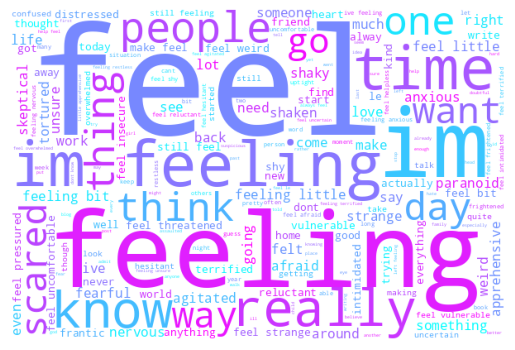

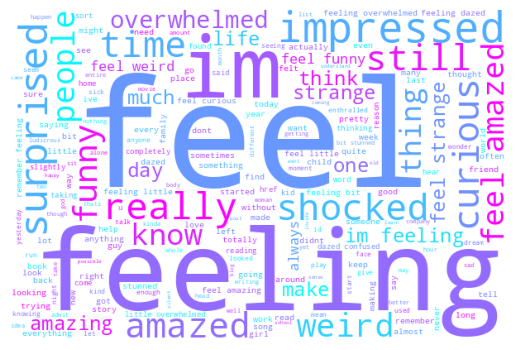

In [36]:
visualize('fear', df, style = 'cool_r')
visualize('surprise', df, style = 'cool_r')

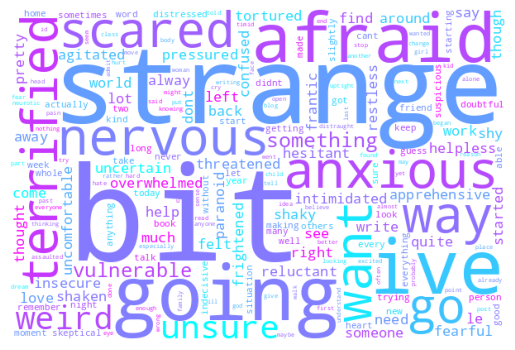

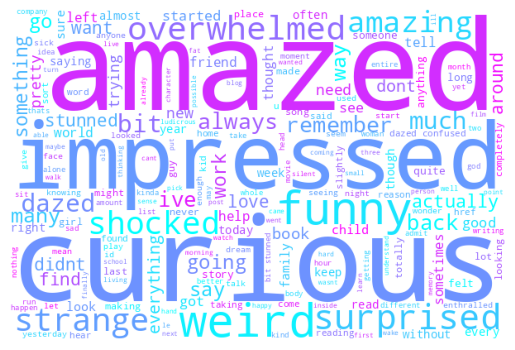

In [37]:
visualize('fear', df_copy, style = 'cool_r')
visualize('surprise', df_copy, style = 'cool_r')

### 3. Prediction

In [38]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_copy['Sentence'], df_copy['Emotion'], test_size=0.25, random_state=42)

In [40]:
cv = CountVectorizer()

In [41]:
X_tr_train = cv.fit_transform(X_train)
X_tr_test = cv.transform(X_test)

In [42]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_tr_train, y_train)
predicted = clf.predict(X_tr_test)

print(classification_report(y_test.tolist(), predicted))

              precision    recall  f1-score   support

       anger       0.76      0.72      0.74       557
        fear       0.74      0.68      0.71       520
         joy       0.80      0.87      0.83      1481
        love       0.68      0.59      0.63       393
     sadness       0.79      0.83      0.81      1265
    surprise       0.67      0.38      0.49       177

    accuracy                           0.77      4393
   macro avg       0.74      0.68      0.70      4393
weighted avg       0.77      0.77      0.77      4393



In [43]:
clf = GradientBoostingClassifier()
clf.fit(X_tr_train, y_train)
predicted = clf.predict(X_tr_test)

print(classification_report(y_test.tolist(), predicted))

              precision    recall  f1-score   support

       anger       0.94      0.75      0.83       557
        fear       0.91      0.74      0.81       520
         joy       0.72      0.95      0.82      1481
        love       0.85      0.74      0.79       393
     sadness       0.95      0.79      0.86      1265
    surprise       0.74      0.77      0.76       177

    accuracy                           0.83      4393
   macro avg       0.85      0.79      0.81      4393
weighted avg       0.85      0.83      0.83      4393



In [108]:
tv = TfidfVectorizer(use_idf=True,                                                     
                    #ngram_range=(1,2),
                    min_df=0.0015, #  activating this parameter lead to a better training of the NB and worse GradBoost 
                    max_df=0.0085, 
                    smooth_idf=True)

In [109]:
X_tv_train = tv.fit_transform(X_train)
X_tv_test = tv.transform(X_test)

In [110]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_tv_train, y_train)
predicted = clf.predict(X_tv_test)

print(classification_report(y_test.tolist(), predicted))

              precision    recall  f1-score   support

       anger       0.90      0.71      0.80       557
        fear       0.87      0.72      0.79       520
         joy       0.75      0.94      0.84      1481
        love       0.89      0.53      0.66       393
     sadness       0.82      0.89      0.85      1265
    surprise       0.94      0.45      0.61       177

    accuracy                           0.81      4393
   macro avg       0.86      0.70      0.76      4393
weighted avg       0.83      0.81      0.81      4393



In [111]:
clf = GradientBoostingClassifier()
clf.fit(X_tv_train, y_train)
predicted = clf.predict(X_tv_test)

print(classification_report(y_test.tolist(), predicted))

              precision    recall  f1-score   support

       anger       0.93      0.75      0.83       557
        fear       0.92      0.72      0.81       520
         joy       0.71      0.93      0.81      1481
        love       0.80      0.73      0.77       393
     sadness       0.95      0.80      0.87      1265
    surprise       0.77      0.76      0.76       177

    accuracy                           0.82      4393
   macro avg       0.85      0.78      0.81      4393
weighted avg       0.84      0.82      0.82      4393

